# Import The Required Libraries

In [25]:
import json
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import jdatetime

# Load JSON File

In [26]:
JSON_PATH = "result.json"

In [27]:
json_path = Path(JSON_PATH)

raw_text = json_path.read_text(encoding="utf-8")

try:
    # Standard JSON (list or dict)
    data = json.loads(raw_text)
    if isinstance(data, dict) and "messages" in data:
        messages = data["messages"]
    else:
        messages = data
    print(f"Loaded {len(messages)} messages from JSON file.")
except json.JSONDecodeError:
    # Fallback: JSONL
    messages = []
    for i, line in enumerate(raw_text.splitlines(), start=1):
        line = line.strip()
        if not line:
            continue
        try:
            messages.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Skipping invalid JSON at line {i}")
    print(f"Loaded {len(messages)} messages from JSONL file.")

Loaded 4596 messages from JSON file.


# Flatten Telegram Text

In [28]:
rows = []

for msg in messages:
    # Combine Telegram text or text_entities into a single string
    if isinstance(msg.get("text"), list):
        full_text = "".join(
            t if isinstance(t, str) else t.get("text", "")
            for t in msg["text"]
        )
    elif isinstance(msg.get("text"), str):
        full_text = msg["text"]
    else:
        full_text = ""

    rows.append({
        "message_id": msg.get("id"),
        "date": msg.get("date"),
        "full_text": full_text
    })

records = pd.DataFrame(rows)

# Convert date to datetime (safe conversion)
records["date"] = pd.to_datetime(records["date"], errors="coerce")

records.head()

,message_id,date,full_text
0,1,2021-09-03 13:57:38,
1,12,2021-09-05 00:24:19,#خبر_مهم\n\nسلام به همه‌ی علموصی ها😍👊🏾\n\n✅این...
2,13,2021-09-05 00:24:25,
3,14,2021-09-05 00:34:39,🧑‍🏫 سید محمد شهرتاش\n🏫 #برق\n📒 بررسی ۱-بررسی۲-...
4,15,2021-09-05 00:35:51,🧑‍🏫 دکتر هاجر فلاحتی\n🏫 #مهندسی_کامپیوتر\n📒 مد...


# Extract Professor Name & Department & Term For EDA

In [29]:
df = records[3:].copy()
df = df[~df["full_text"].str.contains("#رنج_نمرات|#معرفی_استاد", na=False)]
df["professor_name"] = df["full_text"].str.extract(
    r"(?:🧑‍🏫\s*)?([^\n\r]+)\n?\s*🏫"
)

df["department"] = df["full_text"].str.extract(
    r"#([^\s#]+)"
)

df["term_raw"] = df["full_text"].str.extract(
    r"ترم[^\n]*\n?\s*┘\s*([^\n\r]+)"
)

In [30]:
df[["professor_name", "department", "term_raw"]].head()

,professor_name,department,term_raw
3,سید محمد شهرتاش,برق,مهر 99
4,دکتر هاجر فلاحتی,مهندسی_کامپیوتر,بهمن 98
5,علم الهدی,مهندسی_مواد,بهمن 99
6,حجت قاسمی,مکانیک,مهر 98
7,فریبرز قاسمی,مهندسی_کامپیوتر,بهمن 99


# Extract Numeric Ratings (0–10)

In [31]:
ratings = {
    "coherence": "پیوستگی",
    "knowledge": "دانش عمومی",
    "teaching": "انتقال",
    "management": "مدیریت",
    "responsiveness": "پاسخگویی",
    "behavior": "آداب و رفتار"
}

for col, label in ratings.items():
    df[col] = (
        df["full_text"]
        .str.extract(fr"{label}[^\d]*(\d{{1,2}})")
        .astype(float)
        .clip(0, 10)
    )

df[list(ratings.keys())].head()

,coherence,knowledge,teaching,management,responsiveness,behavior
3,8.0,9.0,7.0,9.0,8.0,10.0
4,1.0,2.0,1.0,3.0,2.0,10.0
5,9.0,8.0,10.0,9.0,10.0,10.0
6,10.0,10.0,9.0,9.0,9.0,9.0
7,8.0,10.0,8.0,10.0,7.0,9.0


# EDA

### Basics

In [32]:
print("Total reviews:", len(df))
print("Unique professors:", df["professor_name"].nunique())
print("Departments:", df["department"].nunique())

Total reviews: 4319
Unique professors: 1296
Departments: 18


In [33]:
df.describe()

,message_id,date,coherence,knowledge,teaching,management,responsiveness,behavior
count,4319.000000,4319,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000
mean,2390.500810,2023-08-20 13:34:43.009029888,7.756548,8.071328,7.095416,7.610617,7.475678,8.276193
min,14.000000,2021-09-05 00:34:39,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1199.500000,2022-09-01 05:30:20,7.000000,7.000000,5.000000,6.000000,5.750000,8.000000
50%,2415.000000,2023-07-11 13:29:21,9.000000,10.000000,8.000000,9.000000,9.000000,10.000000
75%,3583.500000,2024-07-08 08:27:10.500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,4727.000000,2025-10-10 14:51:44,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
std,1376.887467,NaN,2.839717,2.763811,3.202743,2.982470,3.166361,2.820096


### Missing Values

In [34]:
df.isna().sum().sort_values(ascending=False)

professor_name    43
term_raw          43
coherence         43
knowledge         43
teaching          43
management        43
responsiveness    43
behavior          43
department        42
message_id         0
date               0
full_text          0
dtype: int64

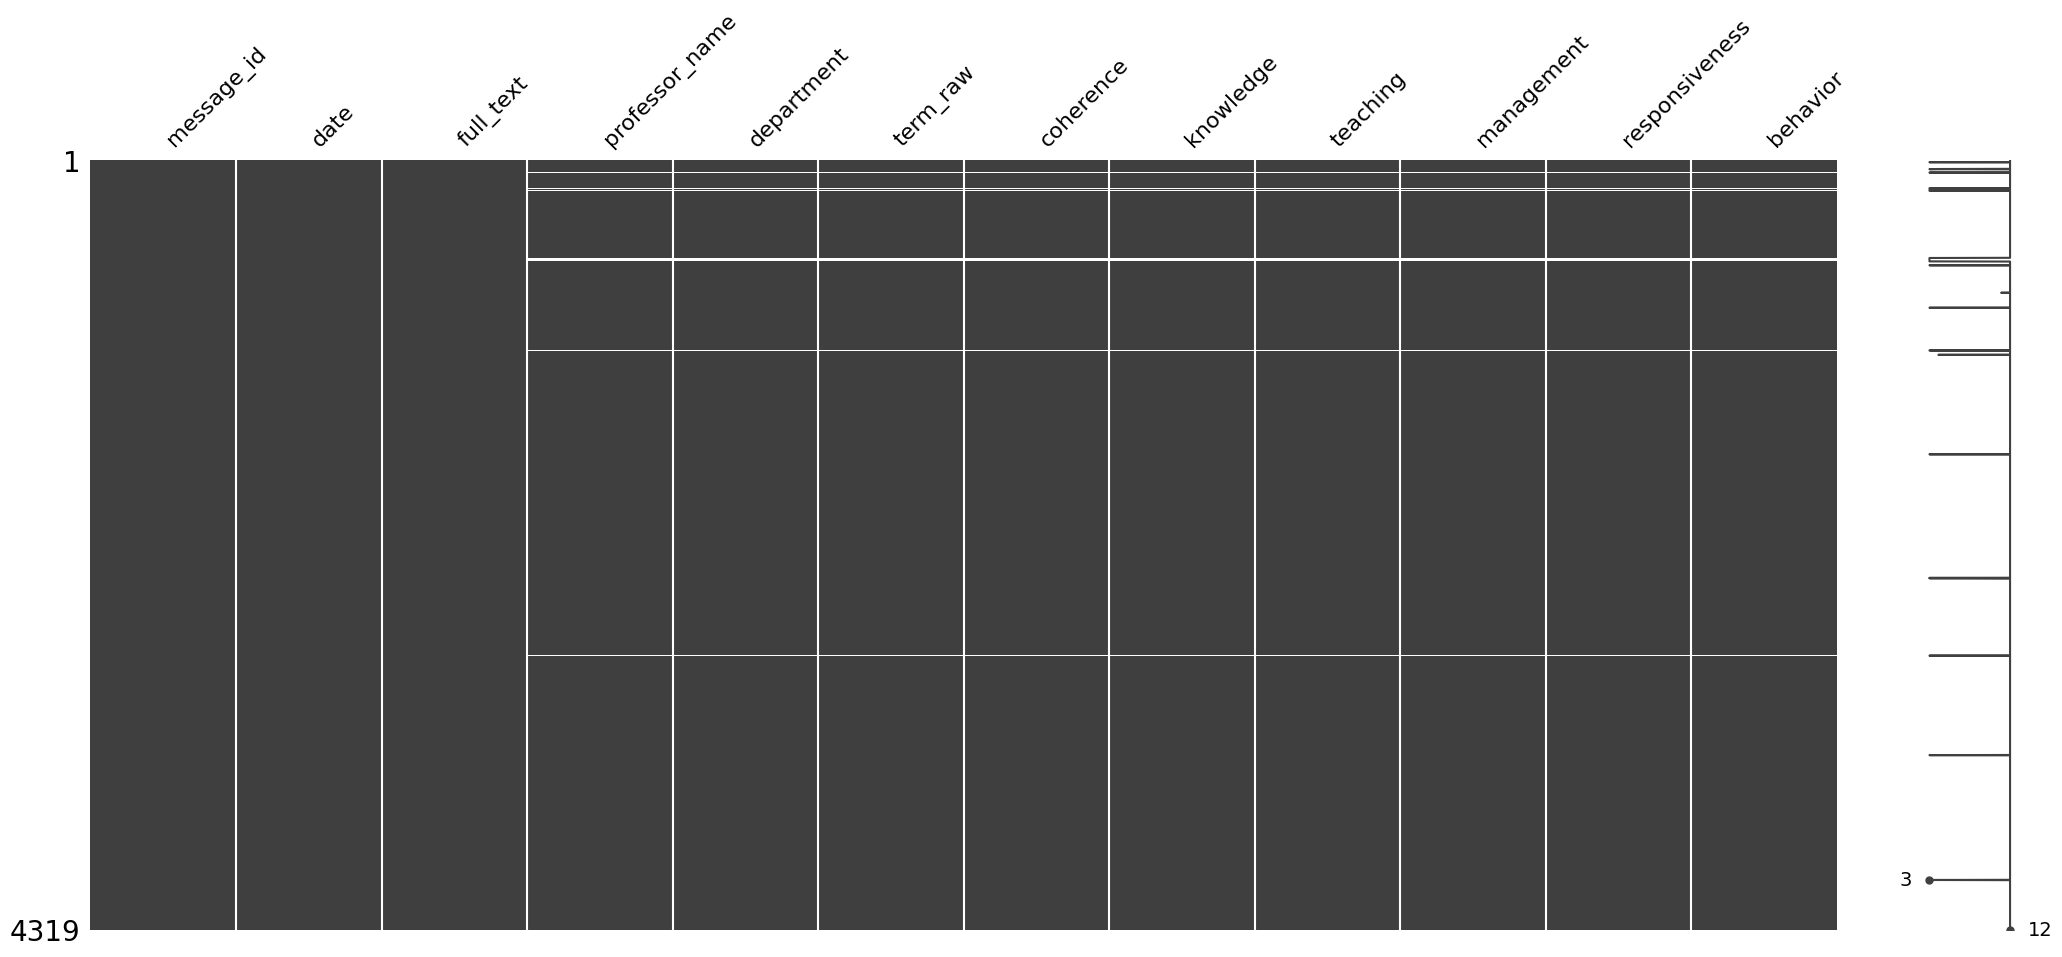

In [35]:
msno.matrix(df)
plt.show()

### Rating Distributions

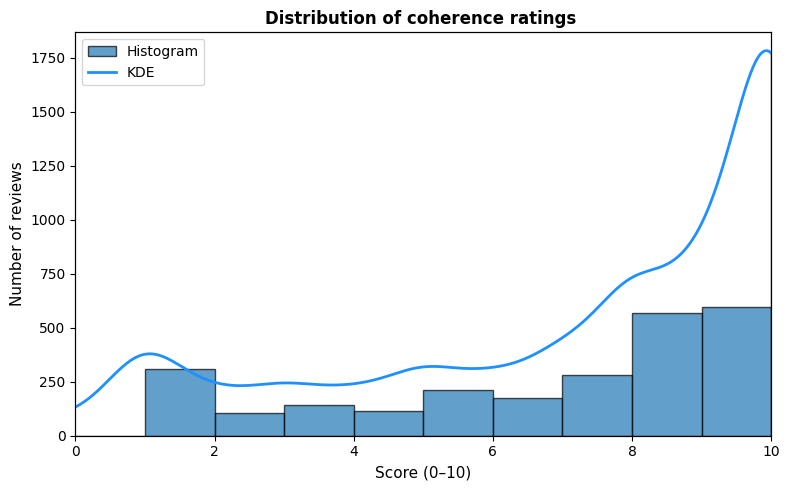

  Mean    : 7.76
  Median  : 9.00
  Std dev : 2.84


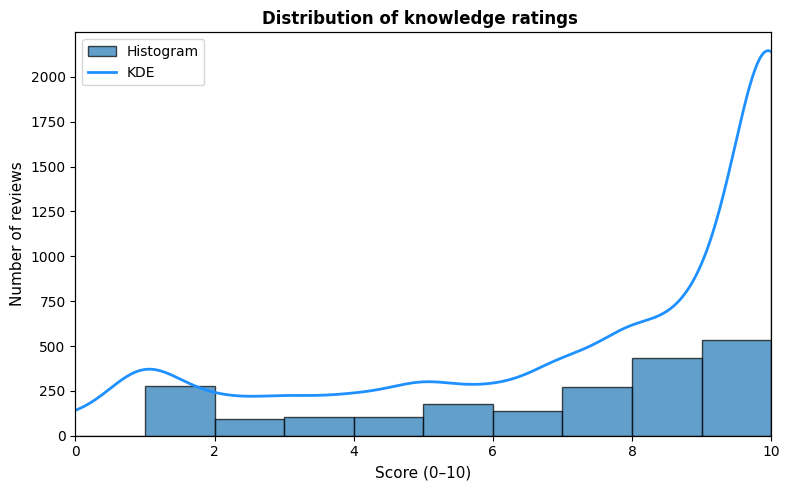

  Mean    : 8.07
  Median  : 10.00
  Std dev : 2.76


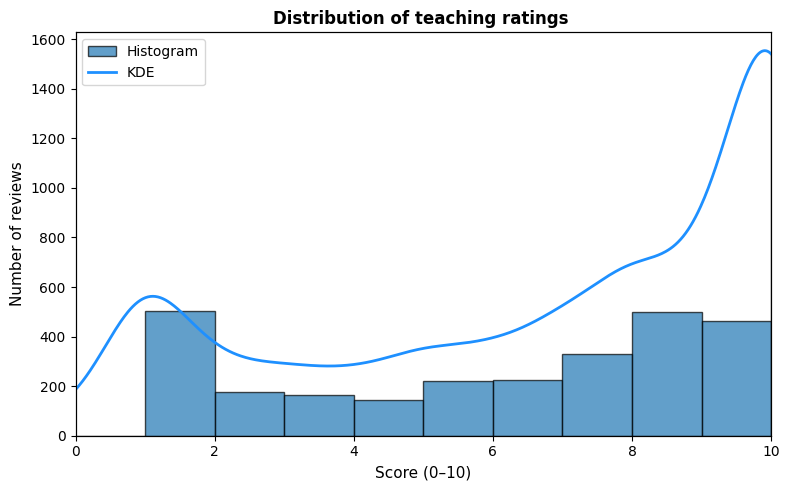

  Mean    : 7.10
  Median  : 8.00
  Std dev : 3.20


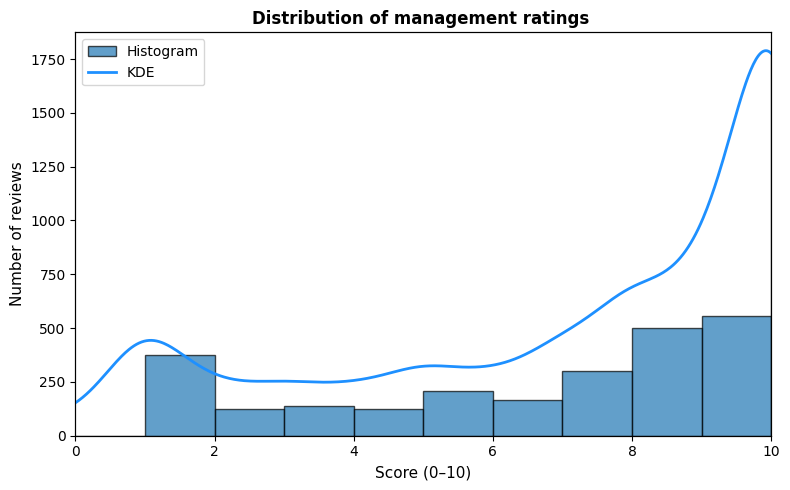

  Mean    : 7.61
  Median  : 9.00
  Std dev : 2.98


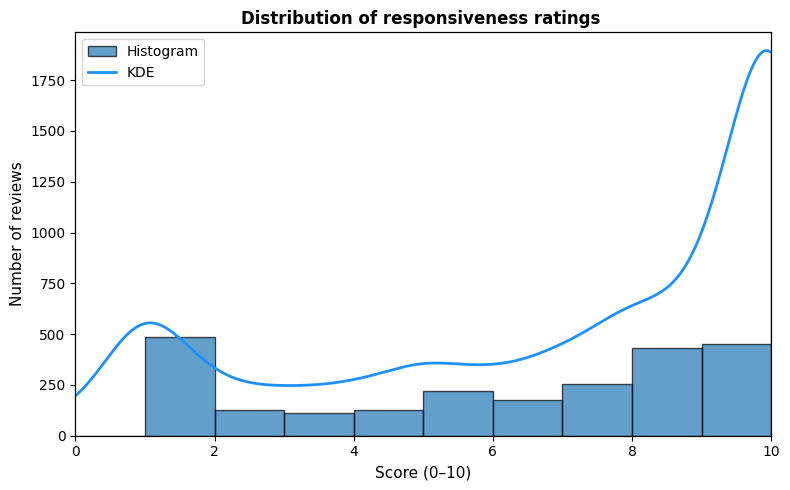

  Mean    : 7.48
  Median  : 9.00
  Std dev : 3.17


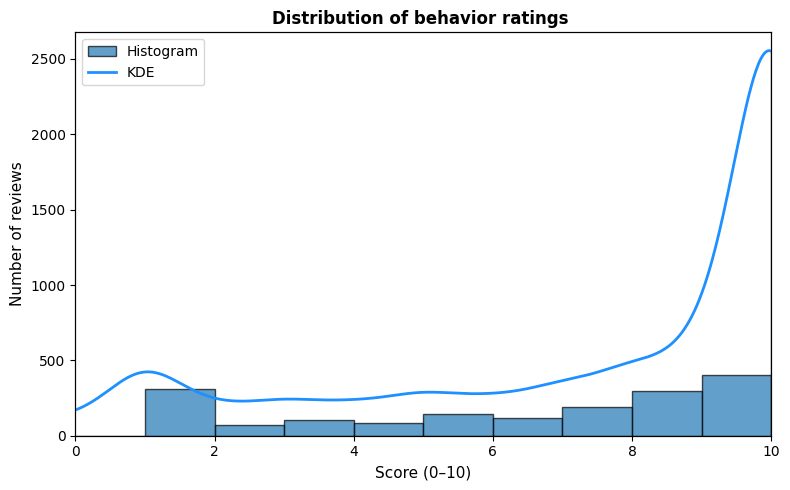

  Mean    : 8.28
  Median  : 10.00
  Std dev : 2.82


In [36]:
rating_cols = list(ratings.keys())

for col in rating_cols:
    data = df[col].dropna()
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    count_val = data.count()

    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    ax1.hist(data, bins=range(0, 12), edgecolor="black", alpha=0.7, label="Histogram")
    ax1.set_xlabel("Score (0–10)", fontsize=11)
    ax1.set_ylabel("Number of reviews", fontsize=11)
    ax1.set_xlim(0, 10)
    
    ax2 = ax1.twinx()
    data.plot(kind="kde", ax=ax2, linewidth=2, color='dodgerblue', label="KDE")
    ax2.set_ylabel('')
    ax2.yaxis.set_visible(False)
    
    hist_handle = ax1.patches[0] if ax1.patches else None
    kde_handle = ax2.lines[0] if ax2.lines else None
    
    if hist_handle and kde_handle:
        ax1.legend([hist_handle, kde_handle], ['Histogram', 'KDE'], loc='upper left')
    
    plt.title(f"Distribution of {col} ratings ", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Numeric summary
    print(f"  Mean    : {mean_val:.2f}")
    print(f"  Median  : {median_val:.2f}")
    print(f"  Std dev : {std_val:.2f}")

<div style="color:#1e3a8a; font-family:'Segoe UI', Roboto, Arial, sans-serif; line-height:1.6; font-size:16px;">
  <p>🔹 The medians are consistently higher than the means for most fields, which suggests <b>right-skewed discrete ratings concentrated at the top</b> (many high scores, a longer left tail of lower scores).</p>

  <p>🔹 <b>Teaching</b> has the lowest mean (7.10) and a larger SD (3.20), indicating <b>wider dispersion</b> and more variability in students' perceived teaching effectiveness compared with other dimensions.</p>

  <p>🔹 <b>Knowledge</b> and <b>Behavior</b> show the highest central tendency (median = 10), implying many raters give <b>top scores on those dimensions.</b></p>

  <p>🔹 In short: most dimensions are skewed toward favorable ratings, but <b>teaching</b> stands out as comparatively lower & more variable.</p>
</div>

### Reviews per Department

In [37]:
temp_dict = {
    'برق': 'EE',
    'مهندسی_کامپیوتر': 'CE',
    'مهندسی_مواد': 'MSE',
    'مکانیک': 'ME',
    'فیزیک': 'PHY',
    'ریاضی': 'MATH',
    'مهندسی_صنایع': 'IE',
    'مهندسی_شیمی': 'CHE',
    'معارف': 'ISL-ST',
    'مهندسی_عمران': 'CIVE',
    'تربیت_بدنی': 'PE',
    'مهندسی_راه_آهن': 'RE',
    'معماری_و_شهرسازی': 'ARCH',
    'شیمی': 'CHEM',
    'طراحی_صنعتی': 'ID',
    'مهندسی_خودرو': 'AE',
    'مهندسی_پیشرفت': 'PE',
    'فناوری_های_نوین': 'MT',
}

df['dept'] = df['department'].map(temp_dict)

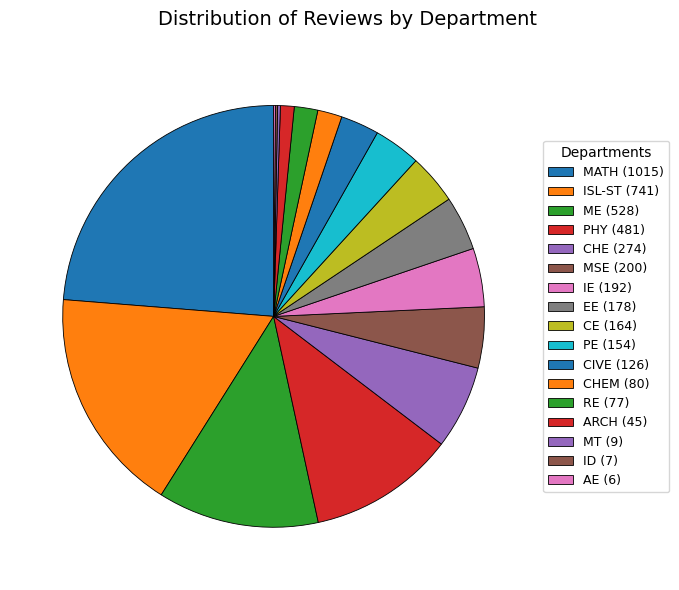

In [38]:
plt.figure(figsize=(10, 6))

dept_counts = df["dept"].value_counts()

wedges, texts = plt.pie(dept_counts.values, startangle=90,
                        textprops={'fontsize': 9}, 
                        wedgeprops={'edgecolor': 'black', 'linewidth': 0.6})

# Hide the percentage labels
plt.title('Distribution of Reviews by Department', loc='right', fontsize=14, pad=20)
plt.ylabel('')

# Legend with department names and counts
legend_labels = [f'{dept} ({count})' for dept, count in zip(dept_counts.index, dept_counts.values)]
plt.legend(wedges, legend_labels, title='Departments', loc='center left',
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=9,
           title_fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

<div style="color:#1e3a8a; font-family:'Segoe UI', Roboto, Arial, sans-serif; line-height:1.6; font-size:16px;">
  <p>🔹 For plotting clarity we used a <b>temporary dictionary</b> to abbreviate department names so labels fit nicely on charts and legends. <b>Original department names</b> are kept in the raw dataframe for traceability.</p>

  <p>🔹 While inspecting department counts we discovered that messages tagged with the hashtag <b><code>#رنج_نمرات</code></b> (grade-range polls that contain images) were being <b>misclassified as departments</b> by the existing regex. These <b><code>#رنج_نمرات</code> posts are not actual review records</b> & should <b>be excluded</b> from the department aggregation. <b>Removing them will also recover some otherwise-missing data fields.</b></p>

  <p>🔹 A notably large share of reviews belongs to the <b>Mathematics</b> and <b>Ma'aref</b> sections. This is expected because <b>many basic science & general-education courses are shared across engineering programs</b>, so those departments appear frequently in the dataset.</p>

  <p>🔹 Other departments with relatively high review counts include <b>Mechanical Engineering</b>, <b>Physics</b>, and <b>Chemical Engineering</b> - all of which show up <b>repeatedly in the review data.</b></p>
</div>

### Average Ratings by Department

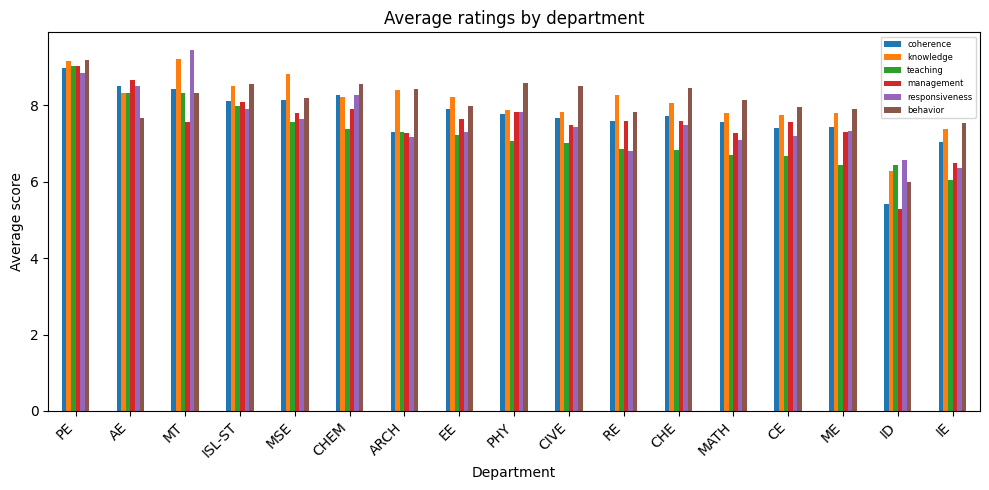

In [39]:
dept_avg = df.groupby("dept")[rating_cols].mean().sort_values("teaching", ascending=False)

ax = dept_avg.plot(kind="bar", figsize=(10, 5))
plt.title("Average ratings by department")
plt.xlabel("Department")
plt.ylabel("Average score")
plt.xticks(rotation=45, ha="right")

plt.legend(fontsize=6, title_fontsize=7)
plt.tight_layout()
plt.show()

<div style="color:#1e3a8a; font-family:'Segoe UI', Roboto, Arial, sans-serif; line-height:1.6; font-size:16px;">
  <p>🔹 Preliminary department averages (visual inspection of the department bar charts) indicate that <b>Industrial Engineering</b> & <b>Industrial Design</b> tend to have <b>relatively lower mean ratings</b> across the rating dimensions than many other departments. The number of reviews for these departments is also moderate, lending some credibility to this observed difference.</p>

  <p>🔹 However, departmental averages should be interpreted with caution: departments with <b>small sample sizes</b> will produce unstable means.</p>

  <p>🔹 Departments with <b>fewer than ~50 reviews</b> should be flagged when presenting averages. For example, <b>Automotive Engineering</b> only has <b>6</b> reviews in the current dataset; any mean/median computed for such a small N is <b>not reliable for cross-department comparison.</b></p>
</div>

### Reviews per Academic Term

In [40]:
temp_grouped = {
 ('قبل از سال 94',): 'before_94',

 ('بهمن 94',): 'second_1394',

 ('تابستان 95',): 'summer_1395',
 
 ('مهر 96',): 'first_1396',
 ('تابستان 96',): 'summer_1396',
 
 ('مهر 97',): 'first_1397',
 ('بهمن 97',): 'second_1397',
 
 ('مهر 98',): 'first_1398',
 ('بهمن 98',): 'second_1398',
 
 ('مهر 99',): 'first_1399',
 ('بهمن 99', 'بهمن ۹۹'): 'second_1399',
 ('تابستان 99',): 'summer_1399',
 
 ('مهر 00', 'مهر 1400', 'مهر ۰۰', 'مهر ..', 'مهر ١٤٠٠', 'مهر ۱۴۰۰', 'مهر۱۴۰۰', 'پاییز ۱۴۰۰'): 'first_1400',
 ('4002', 'بهمن 1400', 'بهمن ۱۴۰۰'): 'second_1400',
 ('تابستان 1400', 'تابستان۱۴۰۰'): 'summer_1400',
 ('بهمن 99 ،مهر 1400', 'مهر و بهمن 1400', 'مهر و بهمن ۱۴۰۰', 'هم ترم مهر ۱۴۰۰ و ترم بهمن ۱۴۰۰'): 'both_1400',
 
 ('14011', 'ترم های 4001 - 4002 - 4011', 'مهر 1401', 'مهر ۴۰۱', 'پاییز ۱۴۰۱'): 'first_1401',
 ('بهار 1402', 'بهار ۱۴۰۲', 'بهار ۴۰۲', 'بهمن 1401', 'بهمن ۴۰۱', 'فرودین ۱۴۰۲'): 'second_1401',
 ('تابستان 1401',): 'summer_1401',
 ('مهر 1401 و بهمن 1402',): 'both_1401',

 ('1402 پاییز', 'مهر 1402', 'مهر 402', 'مهر ۱۴۰۲', 'مهر ۴۰۲', 'مهر۱۴۰۲', 'مهر۴۰۲', 'مهر 1402 - بهمن 1402', 'مهر ۱۴۰۲-بهمن ۱۴۰۲', 'بهمن۱۴۰۱_مهر۱۴۰۲', 'پاییز  ۱۴۰۲', 'پاییز 1402', 'پاییز 402', 'پاییز ۱۴۰۲', '۱۴۰۲ مهر', '۱۴۰۲-۱'): 'first_1402',
 ('4022', 'اسفند 1402', 'اسفند ۱۴۰۲', 'بهار 1403', 'بهار ۱۴۰۳', 'بهار ۴۰۳', 'بهار 403', 'بهتر ۴۰۳', 'بهمن ۱۰۴۲', 'بهمن ۴۰۲ ۴۰۳', 'بهمن۴۰۲-۳', 'بهمن 1402', '1402 بهمن', '1402بهمن', 'بهمن  1402', 'بهمن 1402-1403', 'بهمن 402', 'بهمن ۱۴۰۲', 'بهمن ۴۰۲', 'بهمن۱۴۰۲', 'ترم دو ۱۴۰۲_۱۴۰۳', 'زمستان ۱۴۰۲', 'زمستان ۴۰۲', 'زمستان 402', 'خرداد ۴۰۳', 'زمستان ۱۴۰۲ و بهار ۱۴۰۳', 'زمستان ۴۰۳', '۱۴۰۲٫۱۴۰۳', '۱۴۰۲_۱۴۰۳', '۴۰۲.۲'): 'second_1402',
 ('تابستان 1402',): 'summer_1402',
 ('1402', '۱۴۰۲', 'اول و دوم ۱۴۰۲', 'مهر 1402 و بهمن 1402', 'مهر و بهمن ۴۰۲', '۱۴۰۲ ۱۴۰۳'): 'both_1402',
 
 ('1403 مهر', '403', '4031', 'مهر 1403', 'مهر 403', 'مهر ۱۴٠۳', 'مهر ۱۴۰۳', 'مهر ١۴٠٣', 'مهر ۴۰۳', 'مهر1403', 'مهر403', 'مهر۱۴۰۳', 'مهر۴۰۳', 'مهر۴۰۳- بهمن۴۰۳', 'نیمه اول ۱۴۰۳', 'پائیز 1403', 'پاییز 1403', 'پاییز 403', 'پاییز ۱۴۰۳', 'پاییز ۴۰۳', 'پاییز۴۰۳'): 'first_1403',
 ('1403-2', '4032', '403_2', 'بهار ۱۴۰۴', 'بهار ۴۰۴','بهمن 1403', 'بهمن 403', 'بهمن ١٤٠٣', 'بهمن ۱۴٠۳', 'بهمن ۱۴۰۳', 'بهمن ۴۰۳', 'بهمن۱۴۰۳', 'بهمن ۴۰۲-۳', 'بهمن۴۰۳', 'ترم زمستان 1403', '۴۰۳-۲', '۴۰۳۲'): 'second_1403',
 ('تابستان 1403', 'تابستان 403', 'تابستان ۱۴۰۳', 'تابستان ۴۰۳'): 'summer_1403',
 ('۱۴۰۳', '۴۰۳', 'آبان و بهمن ۱۴۰۳', 'بهمن ۱۴۰۳ و مهر ۱۴۰۳', 'مهر و بهمن 1403', 'مهر و بهمن ۴۰۳', 'مهر ۱۴۰۳ و بهمن ۴۰۳-۴۰۴', 'مهر۱۴۰۳و بهمن ۱۴۰۳'): 'both_1403',

 ('مهر 1404', '۴۰۴'): 'first_1404',
 ('بهمن 1404', 'بهمن ۱۴۰۴', 'بهمن ۴۰۴'): 'second_1404',
 ('تابستان 1404', 'تابستان ۴٠۴'): 'summer_1404'
}

flat_mapping = {
    key: value
    for keys, value in temp_grouped.items()
    for key in keys
}

In [41]:
df['term'] = (
    df['term_raw']
      .astype(str)
      .str.strip()
      .str.replace(r'([آ-یA-Za-z]+)([0-9]+)', r'\1 \2', regex=True)
      .map(flat_mapping)
)

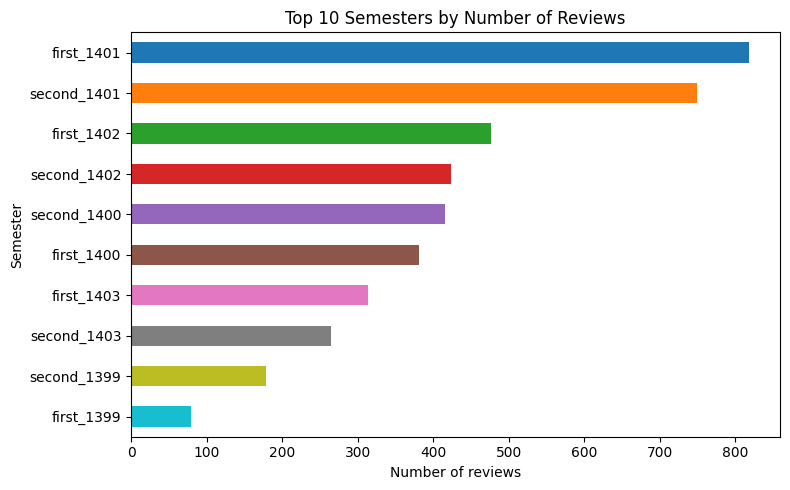

In [42]:
# Take top 10 terms by number of reviews
top_terms = df["term"].value_counts().sort_index().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
colors = plt.cm.tab10.colors
top_terms.plot(
    kind="barh",
    color=colors,
)
plt.xlabel("Number of reviews")
plt.ylabel("Semester")
plt.title("Top 10 Semesters by Number of Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [43]:
df["shamsi"] = df["date"].apply(lambda d:jdatetime.date.fromgregorian(year=d.year, month=d.month,day=d.day).year)
df["year"] = df["term"].str.extract(r"(\d{4})").astype(float).fillna(-1).astype(int)

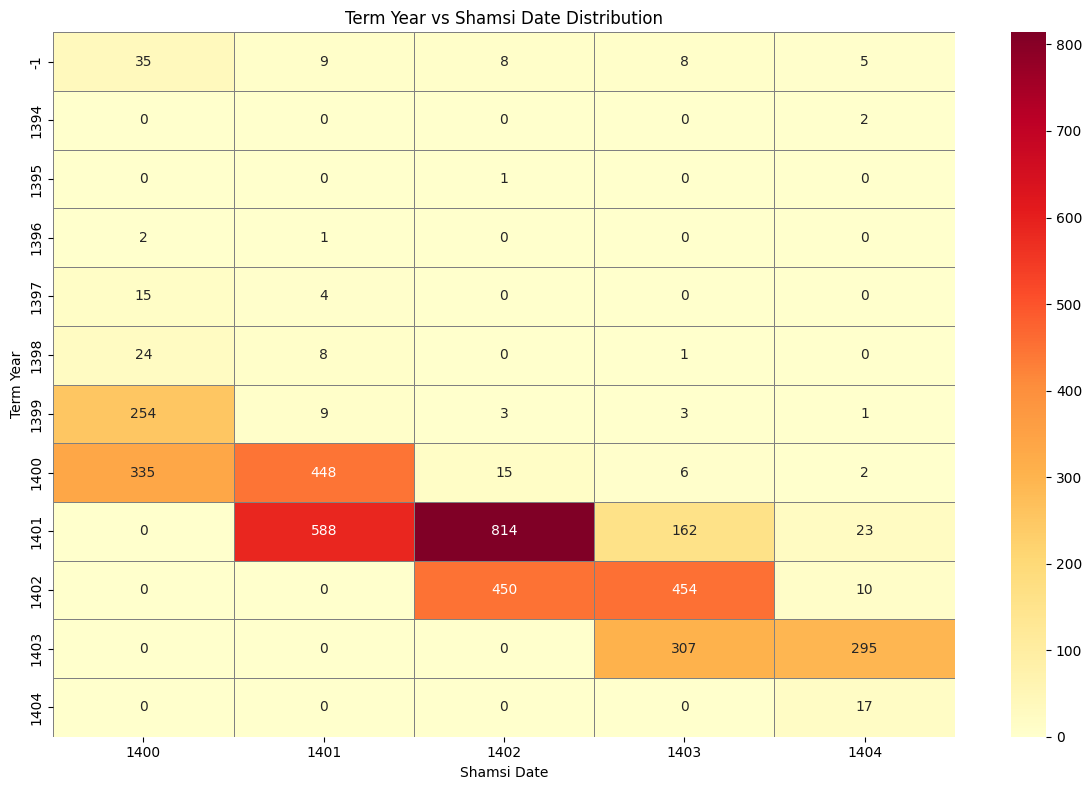

In [44]:
year_matrix = df.groupby(["year", "shamsi"]).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(
    year_matrix, 
    annot=True, 
    fmt='d',
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Term Year vs Shamsi Date Distribution')
plt.xlabel('Shamsi Date')
plt.ylabel('Term Year')
plt.tight_layout()
plt.show()

<div style="color:#1e3a8a; font-family:'Segoe UI', Roboto, Arial, sans-serif; line-height:1.6; font-size:16px;">
  <p>🔹 Proceeding with the EDA, Semester-related fields seemed like a strong candidate for analysis & clearly needed to be normalized first.</p>

  <p>🔹 For normalizing and unifying the data in the <code><b>term</code></b> column, we initially attempted to use <b>regex and string operations in an algorithmic way</b>. However, in practice, this didn't result in a very robust or precise solution, as <b>various patterns & edge cases kept causing issues.</b></p>

  <p>🔹 Therefore, given the easy availability and access to various LLMs, we sent the unique values as an array to them to generate a <b><code>grouped_mapping</code></b> for this purpose - similar to what was done for the <b><code>department</code></b>. This approach might not be very common and may not be suitable for when we need to process data in real-time. Nevertheless, in the current <b>EDA phase</b>, it proved to be a <b>very robust and accurate method</b>.</p>

  <p>🔹 Moreover, in terms of complexity, it is naturally more efficient. <b>Combining LLMs with our own general oversight made the task quick and effective.</b></p>

  <p>🔹 The top 10 bar chart illustrates two clear patterns: <b>reviews are predominantly concentrated in recent academic years (1400-1403)</b>, and there is a consistent <b>cyclical trend where <code>first_</code> (Fall) semesters consistently receive a higher volume of reviews.</b></p>

  <p>🔹 We also extracted the <b>Shamsi year</b> from each message's date and created a <b>comparative matrix with the academic year</b> we derived from the semester data.</p>

  <p>🔹 This allowed us to see if, for a subset of reviews where the date might not have been entered correctly (although their number is quite small), we could potentially <b>use the message date instead</b>.</p>

  <p>🔹 Beyond that, it helped us examine <b>what relationship generally exists between the date a message was posted and the semester in which the student took the course</b> with the professor.</p>

  <p>🔹 Logically, most values are either similar or differ by at most one year, which is precisely <b>what the chart reveals in more detail</b> (Strong diagonal dominance).</p>
  
  <p>🔹Entries with <b><code>term year == -1</b></code> (unknown) are <b>relatively rare and evenly distributed</b>, indicating that normalization was largely successful.</p>
</div>
